# Financial Influence

## Setup

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from IPython.display import display

## Key Terms

### Salary Cap  
The official spending limit set by the NBA on total player salaries per team each season.

### Team Salary (Team Cap)  
The actual total amount a team disburses on player contracts. Can be below, equal to, or above the official cap.

### Soft Cap System  
A cap structure that allows teams to exceed the salary cap under specific exceptions, such as:  
- **Bird Rights**: Re-signing own players above the cap  
- **Mid-Level Exception**: Signing free agents even when over the cap  
- **Rookie Exception**: Draft picks don’t count against the cap

### Luxury Tax  
A financial penalty paid by teams that exceed a designated tax threshold. The more they exceed it, the higher the tax rate.

## Salary Cap

The salary cap data was exported from Basketball Reference, a highly trusted and widely used website for historical and statistical NBA data. You can find the full salary-cap history here:
https://www.basketball-reference.com/contracts/salary-cap-history.html

Basketball Reference is part of the Sports Reference network and is regularly cited by journalists, analysts, and researchers in the sports industry. The inflation-adjusted values (“2022 Dollars”) were provided directly on the site, based on Consumer Price Index (CPI) data from the Minneapolis Federal Reserve. On that page, you can also download the dataset as a CSV file.

In [10]:
import pandas as pd

# Local path to the downloaded CSV file
file_path = r"C:\Users\chris\Documents\nba_data\data\NBA_Salary_Cap_History.csv"

# Read the CSV into a DataFrame
salary_cap_history = pd.read_csv(file_path)

# Convert the "2022 Dollars" column to integer type
salary_cap_history["2022 Dollars"] = salary_cap_history["2022 Dollars"].astype("Int64")

# Display the first few rows
print(salary_cap_history)

     Season  Salary Cap  2022 Dollars
0   1984-85     3600000       9793069
1   1985-86     4233000      11298280
2   1986-87     4945000      12734751
3   1987-88     6164000      15248702
4   1988-89     7232000      17069461
5   1989-90     9802000      21950887
6   1990-91    11871000      25499592
7   1991-92    12500000      26061180
8   1992-93    14000000      28354756
9   1993-94    15175000      29954782
10  1994-95    15964000      30651995
11  1995-96    23000000      42906004
12  1996-97    24363000      44402880
13  1997-98    26900000      48285994
14  1998-99    30000000      52688773
15  1999-00    34000000      57763864
16  2000-01    35500000      58657395
17  2001-02    42500000      69132284
18  2002-03    40271000      64048956
19  2003-04    43840000      67907202
20  2004-05    43870000      65719039
21  2005-06    49500000      71839551
22  2006-07    53135000      74973988
23  2007-08    55630000      75594893
24  2008-09    58680000      80023973
25  2009-10 

### Note on Missing Inflation-Adjusted Values

The seasons **2022-23** and **2023-24** originally show `<NA>` in the `2022 Dollars` column. To fill these gaps, we used the Minneapolis Fed Inflation Calculator:  
https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/

- **2022-23**: \$1 in 2023 is worth \$0.96 in 2022 → multiplied raw cap by **0.96**  
- **2023-24**: \$1 in 2024 is worth \$0.93 in 2022 → multiplied raw cap by **0.93**

The **2024-25** season remains `<NA>`, since CPI data for that period are not yet finalized.

In [11]:
# Manually fill in the missing “2022 Dollars” for seasons 2022-23 and 2023-24
# using the Minneapolis Fed inflation factors we looked up:

# 2022-23: $1 in 2023 ≈ $0.96 in 2022
mask_22_23 = salary_cap_history["Season"] == "2022-23"
salary_cap_history.loc[mask_22_23, "2022 Dollars"] = (
    salary_cap_history.loc[mask_22_23, "Salary Cap"] * 0.96
)

# 2023-24: $1 in 2024 ≈ $0.93 in 2022
mask_23_24 = salary_cap_history["Season"] == "2023-24"
salary_cap_history.loc[mask_23_24, "2022 Dollars"] = (
    salary_cap_history.loc[mask_23_24, "Salary Cap"] * 0.93
)

# Drop any remaining rows with missing “2022 Dollars” (e.g. 2024-25)
salary_cap_history = salary_cap_history.dropna(subset=["2022 Dollars"]).reset_index(drop=True)

# Display the last two rows (2022-23 and 2023-24)
print(salary_cap_history.tail(2))

     Season  Salary Cap  2022 Dollars
38  2022-23   123655000     118708800
39  2023-24   136021000     126499530


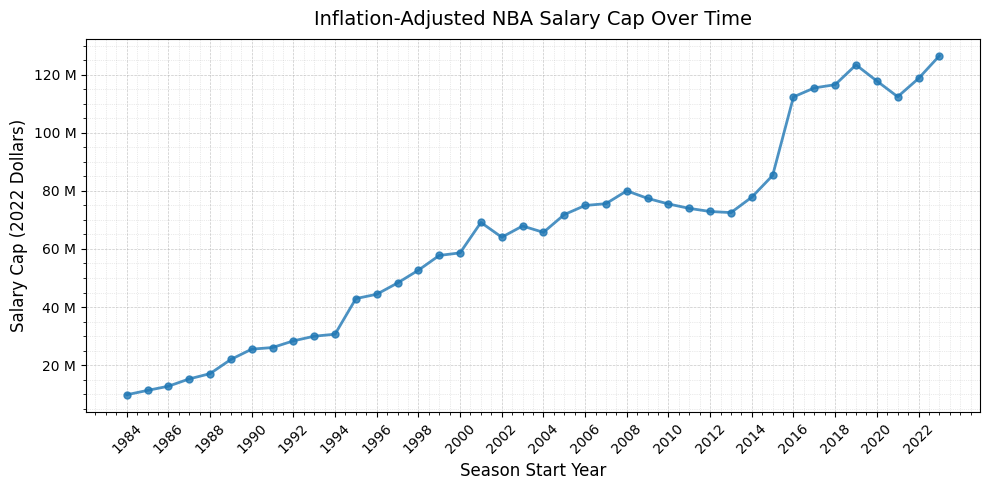

In [12]:
# Ensure numeric "YearStart" column exists
salary_cap_history['YearStart'] = (
    salary_cap_history['Season']
    .str.split('-')
    .str[0]
    .astype(int)
)

# Create figure & axis
fig, ax = plt.subplots(figsize=(10, 5))

# Plot with markers, thicker line and slight transparency
ax.plot(
    salary_cap_history['YearStart'],
    salary_cap_history['2022 Dollars'],
    marker='o',
    linewidth=2,
    markersize=5,
    alpha=0.8
)

# Format y-axis labels in millions
ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f"{x/1e6:.0f} M")
)

# Major and minor grid lines
ax.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Labels and title
ax.set_xlabel('Season Start Year', fontsize=12)
ax.set_ylabel('Salary Cap (2022 Dollars)', fontsize=12)
ax.set_title('Inflation-Adjusted NBA Salary Cap Over Time', fontsize=14, pad=10)

# Ticks: every 2 seasons, rotated
years = salary_cap_history['YearStart']
ax.set_xticks(years[::2])
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Slow and Steady Rise: From the mid-1980s through the early 2010s, the salary cap (adjusted for inflation) climbed gradually.

2008–09 Dip: During the global financial crisis, NBA revenue took a small hit, so the cap leveled off for a couple of seasons.

Big 2015–16 Jump: Then, thanks to a massive new TV deal—$24 billion over nine years with ESPN/ABC and Turner—the cap jumped from around $68 million to $90 million in one season (a 30 percent spike). For details on that agreement, see the Sports Illustrated article: https://www.si.com/nba/2014/10/06/new-nba-tv-deal-worth-24-billion

Continued Growth: After that, the cap kept rising to new highs, driven by further media contracts and the NBA’s expanding global business.

## Team Salary

### NBA Team Salary Data Extraction

In this section, we scrape team payroll figures from (https://hoopshype.com/salaries/) for each season between 1990-91 and 2024-25. The script retrieves both nominal and inflation-adjusted salaries, saves them to a CSV, and prepares the data for subsequent analysis of team spending trends.

In [29]:
# Define seasons: from 1990/91 to 2024/25
seasons = [f"{year}/{str(year+1)[-2:]}" for year in range(1990, 2025)]
season_urls = [f"{year}{str(year+1)[-2:]}" for year in range(1990, 2025)]

# Base URL of HoopsHype
base_url = "https://hoopshype.com/salaries/"

# List to store all extracted rows
all_data = []

# Loop through each season URL
for season, season_url in zip(seasons, season_urls):
    url = f"{base_url}{season_url}/"
    print(f"Fetching data for {season} from {url}")
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        # Select table rows
        rows = soup.select("table tbody tr")

        for row in rows:
            cols = row.find_all("td")
            if len(cols) >= 4:
                team = cols[1].get_text(strip=True)
                nominal_salary = cols[2].get_text(strip=True).replace("$", "").replace(",", "")
                adjusted_salary = cols[3].get_text(strip=True).replace("$", "").replace(",", "")

                all_data.append({
                    "Season": season,
                    "Team": team,
                    "Team Salary": int(nominal_salary) if nominal_salary.isdigit() else None,
                    "Team Salary Adjusted": int(adjusted_salary) if adjusted_salary.isdigit() else None
                })

        time.sleep(1)  # Wait between requests to be polite to the server

    except Exception as e:
        print(f"Error fetching {season}: {e}")

# Create DataFrame with new name
team_salaries = pd.DataFrame(all_data)

# Save to CSV
team_salaries.to_csv("team_salaries_1990_2025.csv", index=False)
print("Done. Data saved as 'team_salaries_1990_2025.csv'.")

display(team_salaries.head())

Fetching data for 1990/91 from https://hoopshype.com/salaries/199091/
Fetching data for 1991/92 from https://hoopshype.com/salaries/199192/
Fetching data for 1992/93 from https://hoopshype.com/salaries/199293/
Fetching data for 1993/94 from https://hoopshype.com/salaries/199394/
Fetching data for 1994/95 from https://hoopshype.com/salaries/199495/
Fetching data for 1995/96 from https://hoopshype.com/salaries/199596/
Fetching data for 1996/97 from https://hoopshype.com/salaries/199697/
Fetching data for 1997/98 from https://hoopshype.com/salaries/199798/
Fetching data for 1998/99 from https://hoopshype.com/salaries/199899/
Fetching data for 1999/00 from https://hoopshype.com/salaries/199900/
Fetching data for 2000/01 from https://hoopshype.com/salaries/200001/
Fetching data for 2001/02 from https://hoopshype.com/salaries/200102/
Fetching data for 2002/03 from https://hoopshype.com/salaries/200203/
Fetching data for 2003/04 from https://hoopshype.com/salaries/200304/
Fetching data for 20

,Season,Team,Team Salary,Team Salary Adjusted
0,1990/91,Phoenix,220708856,210624320
1,1990/91,Minnesota,204780898,187794930
2,1990/91,Boston,195598491,223928825
3,1990/91,New York,193588886,194354847
4,1990/91,LA Lakers,192057940,189239092


It is recommended to download the scraped CSV locally (to guard against future website changes) and then load it for analysis:


In [30]:
# Load the team salaries dataset
team_salaries = pd.read_csv(r"C:\Users\chris\Documents\nba_data\data\team_salaries_1990_2025.csv")

# Basic inspections
print("Shape:", team_salaries.shape)
team_salaries.info()
print("\nMissing values per column:\n", team_salaries.isnull().sum())
print("\nSeasons covered:\n", team_salaries["Season"].value_counts().sort_index())

Shape: (1050, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Season                1050 non-null   object
 1   Team                  1050 non-null   object
 2   Team Salary           1050 non-null   int64 
 3   Team Salary Adjusted  1050 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 32.9+ KB

Missing values per column:
 Season                  0
Team                    0
Team Salary             0
Team Salary Adjusted    0
dtype: int64

Seasons covered:
 Season
1990/91    30
1991/92    30
1992/93    30
1993/94    30
1994/95    30
1995/96    30
1996/97    30
1997/98    30
1998/99    30
1999/00    30
2000/01    30
2001/02    30
2002/03    30
2003/04    30
2004/05    30
2005/06    30
2006/07    30
2007/08    30
2008/09    30
2009/10    30
2010/11    30
2011/12    30
2012/13    30
2013/14    30
2014/15    30
2015

In [31]:
team_salaries[team_salaries["Season"] == "2021/22"].sort_values("Team Salary Adjusted", ascending=False)

,Season,Team,Team Salary,Team Salary Adjusted
932,2021/22,Boston,195610488,223928825
930,2021/22,Phoenix,220708856,210624320
946,2021/22,Cleveland,172471107,210534208
936,2021/22,Denver,185864258,203509384
933,2021/22,New York,193588886,194354847
937,2021/22,Dallas,178812859,193550487
934,2021/22,LA Lakers,192057940,189239092
931,2021/22,Minnesota,204780898,187794930
944,2021/22,Toronto,173621417,178613358
939,2021/22,Miami,176102077,176542132


I ran a quick spot check and the scraped salaries match what’s on the site. The scrape finished without errors, and all seasons from 1990-91 to 2024-25 are in the CSV. The dataset is now ready for first-round EDA.